In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

import numpy as np
import dask.array as da
import xarray as xr
import os


from xmitgcm import open_mdsdataset
import xmitgcm
import sys
sys.path.append('/Users/tatsumonkman/3rd_party_software/ECCOv4-py')
import ecco_v4_py as ecco


from netCDF4 import Dataset

from analysis_package import plotting_functions
from analysis_package import open_datasets
from analysis_package import ecco_masks

from importlib import reload

# reload modules for prototyping...
ecco_masks = reload(ecco_masks)
plotting_functions = reload(plotting_functions)
open_datasets = reload(open_datasets)


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
######################################################################################################################
################################################### LOAD GRID ########################################################
######################################################################################################################
grid_path = "./ECCO-GRID.nc"
grid = xr.open_dataset(grid_path)
AMOC_bottom_of_surf = xr.open_dataset("./amoc_botsurf_N.nc")



In [143]:
######################################################################################################################
############################################# CREATE DOMAIN MASKS ####################################################
######################################################################################################################

ecco_masks = reload(ecco_masks)
maskW = xr.open_dataarray("generic_masks/maskW.nc")
maskS = xr.open_dataarray("generic_masks/maskS.nc")
maskC = xr.open_dataarray("generic_masks/maskC.nc")


southern_ocean_mask_W, southern_ocean_mask_S, southern_ocean_mask_C, so_atl_basin_mask_W, so_atl_basin_mask_S, so_atl_basin_mask_C, so_indpac_basin_mask_W, so_indpac_basin_mask_S, so_indpac_basin_mask_C = ecco_masks.get_basin_masks(maskW, maskS, maskC)


baffin_mask_C = ecco.get_basin_mask("baffin",maskC)
north_mask_C = ecco.get_basin_mask("north",maskC)
hudson_mask_C = ecco.get_basin_mask("hudson",maskC)
gin_mask_C = ecco.get_basin_mask("gin",maskC)
bering_mask_C = ecco.get_basin_mask("bering",maskC)
okhotsk_mask_C = ecco.get_basin_mask("okhotsk",maskC)
atl_mask_C = ecco.get_basin_mask("atl",maskC)

gin_mask_W = ecco.get_basin_mask("gin",maskW)
gin_mask_S = ecco.get_basin_mask("gin",maskS)
north_mask_W = ecco.get_basin_mask("north",maskW)
north_mask_S = ecco.get_basin_mask("north",maskS)




atl_nogin_basin_mask_C = so_atl_basin_mask_C.where(so_atl_basin_mask_C.lat>-32,other=np.nan).where((gin_mask_C+north_mask_C < 1).values,other=np.nan)

so_atl_nogin_basin_mask_C = so_atl_basin_mask_C.where((gin_mask_C+north_mask_C < 1).values,other=np.nan)
so_atl_nogin_basin_mask_W = so_atl_basin_mask_W.where((gin_mask_W+north_mask_W < 1).values,other=np.nan)
so_atl_nogin_basin_mask_S = so_atl_basin_mask_S.where((gin_mask_S+north_mask_S < 1).values,other=np.nan)




atl_nogin_basin_mask_C = so_atl_basin_mask_C.where((gin_mask_C+north_mask_C < 1).values,other=np.nan)
atl_nogin_basin_mask_C_special_mask = atl_nogin_basin_mask_C.copy()

atl_nogin_basin_mask_S = so_atl_basin_mask_S.where((gin_mask_S+north_mask_S < 1).values,other=np.nan)
atl_nogin_basin_mask_S_special_mask = atl_nogin_basin_mask_S.copy()
atl_nogin_basin_mask_W = so_atl_basin_mask_W.where((gin_mask_W+north_mask_W < 1).values,other=np.nan)
atl_nogin_basin_mask_W_special_mask = atl_nogin_basin_mask_W.copy()

FINAL_atl_maskC = so_atl_basin_mask_C*atl_nogin_basin_mask_C_special_mask
FINAL_atl_maskS = so_atl_basin_mask_S*atl_nogin_basin_mask_S_special_mask
FINAL_atl_maskW = so_atl_basin_mask_W*atl_nogin_basin_mask_W_special_mask






load_binary_array: loading file /Users/tatsumonkman/3rd_party_software/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
load_binary_array: loading file /Users/tatsumonkman/3rd_party_software/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
load_binary_array: loading file /Users/tatsumonkman/3rd_party_software/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary

In [31]:
SIGMA2 = xr.open_dataarray(f"./SIGMA2_full.nc")

In [33]:
SIGMA2_tmax = SIGMA2.max(dim="time")

In [35]:
SIGMA2_tmax = SIGMA2_tmax.where(SIGMA2_tmax>1010,other=np.nan)

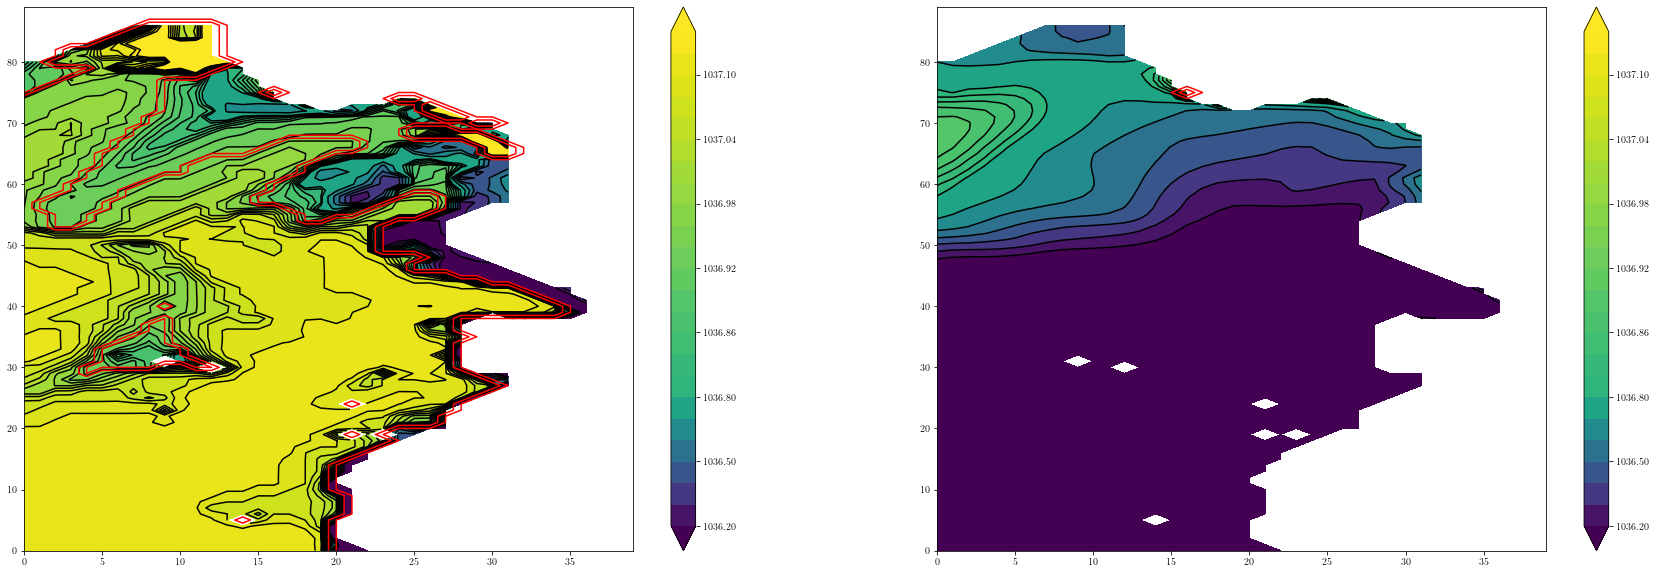

In [93]:
fig,axs = plt.subplots(1,2,figsize=(30,10))

levels=np.concatenate((np.arange(1036.2,1036.8,0.1),np.arange(1036.8,1037.15,0.02)))

im0 = axs[0].contourf(SIGMA2_tmax.isel(tile=2,i=np.arange(0,40)).max(dim="k")*FINAL_atl_maskC.isel(tile=2),levels=levels,extend="both")
axs[0].contour(SIGMA2_tmax.isel(tile=2,i=np.arange(0,40)).max(dim="k")*FINAL_atl_maskC.isel(tile=2),levels=levels,colors="k")
axs[0].contour(SIGMA2_tmax.isel(tile=2,i=np.arange(0,40)).max(dim="k")*FINAL_atl_maskC.isel(tile=2)>1036.95,levels=1,colors="r")




im1 = axs[1].contourf(SIGMA2_tmax.isel(tile=2,k=0,i=np.arange(0,40))*FINAL_atl_maskC.isel(tile=2),levels=levels,extend="both")
axs[1].contour(SIGMA2_tmax.isel(tile=2,k=0,i=np.arange(0,40))*FINAL_atl_maskC.isel(tile=2),levels=levels,colors="k")
axs[1].contour(SIGMA2_tmax.isel(tile=2,k=0,i=np.arange(0,40))*FINAL_atl_maskC.isel(tile=2)>1036.95,levels=1,colors="r")



cm0 = fig.colorbar(im0,ax=axs[0])
cm1 = fig.colorbar(im1,ax=axs[1])

plt.show()
plt.close()

In [145]:
mod_FINAL_atl_maskC = FINAL_atl_maskC.copy()
mod_FINAL_atl_maskS = FINAL_atl_maskS.copy()
mod_FINAL_atl_maskW = FINAL_atl_maskW.copy()

region_0_mask = (SIGMA2_tmax.isel(tile=2,i=i_range0,j=j_range0).max(dim="k")>1036.98).fillna(0)
region_1_mask = (SIGMA2_tmax.isel(tile=2,i=i_range1,j=j_range1).max(dim="k")>1036.98).fillna(0)
region_2_mask = (SIGMA2_tmax.isel(tile=2,i=i_range2,j=j_range2).max(dim="k")>1036.98).fillna(0)
region_0_mask = region_0_mask.where(region_0_mask<1,other=np.nan)*0+1
region_1_mask = region_1_mask.where(region_1_mask<1,other=np.nan)*0+1
region_2_mask = region_2_mask.where(region_2_mask<1,other=np.nan)*0+1



mod_FINAL_atl_maskC.loc[{"tile":2,"i":i_range0,"j":j_range0}] = mod_FINAL_atl_maskC.loc[{"tile":2,"i":i_range0,"j":j_range0}].values*region_0_mask.values
mod_FINAL_atl_maskC.loc[{"tile":2,"i":i_range1,"j":j_range1}] = mod_FINAL_atl_maskC.loc[{"tile":2,"i":i_range1,"j":j_range1}].values*region_1_mask.values
mod_FINAL_atl_maskC.loc[{"tile":2,"i":i_range2,"j":j_range2}] = mod_FINAL_atl_maskC.loc[{"tile":2,"i":i_range2,"j":j_range2}].values*region_2_mask.values

mod_FINAL_atl_maskS.loc[{"tile":2,"i":i_range0,"j_g":j_range0}] = mod_FINAL_atl_maskS.loc[{"tile":2,"i":i_range0,"j_g":j_range0}].values*region_0_mask.values
mod_FINAL_atl_maskS.loc[{"tile":2,"i":i_range1,"j_g":j_range1}] = mod_FINAL_atl_maskS.loc[{"tile":2,"i":i_range1,"j_g":j_range1}].values*region_1_mask.values
mod_FINAL_atl_maskS.loc[{"tile":2,"i":i_range2,"j_g":j_range2}] = mod_FINAL_atl_maskS.loc[{"tile":2,"i":i_range2,"j_g":j_range2}].values*region_2_mask.values

mod_FINAL_atl_maskW.loc[{"tile":2,"i_g":i_range0,"j":j_range0}] = mod_FINAL_atl_maskW.loc[{"tile":2,"i_g":i_range0,"j":j_range0}].values*region_0_mask.values
mod_FINAL_atl_maskW.loc[{"tile":2,"i_g":i_range1,"j":j_range1}] = mod_FINAL_atl_maskW.loc[{"tile":2,"i_g":i_range1,"j":j_range1}].values*region_1_mask.values
mod_FINAL_atl_maskW.loc[{"tile":2,"i_g":i_range2,"j":j_range2}] = mod_FINAL_atl_maskW.loc[{"tile":2,"i_g":i_range2,"j":j_range2}].values*region_2_mask.values

In [384]:
mod_FINAL_atl_maskC.to_netcdf("mod_FINAL_atl_maskC2.nc")

In [342]:
def integrate_over_lat_bands(trsp_x,trsp_y,time_output,time_slice,lat_vals=np.arange(-88,88)):
    ######################################################################################################################
    ################################################### LOAD GRID ########################################################
    ######################################################################################################################

    grid_path = "./ECCO-GRID.nc"
    grid = xr.open_dataset(grid_path)
    cds = grid.coords.to_dataset()
    grid_xmitgcm = ecco.ecco_utils.get_llc_grid(cds)

    
    if time_output == False:
        pot_dens_dims = (len(trsp_x.sig),len(lat_vals))
        empty_pot_coords_data = np.zeros(pot_dens_dims)
        new_coords = [trsp_x.sig,lat_vals]
        new_dims = ["sig", "lat"]
    elif time_output == True:
        pot_dens_dims = (len(trsp_x.sig),len(lat_vals),len(time_slice))
        empty_pot_coords_data = np.zeros(pot_dens_dims)
        new_coords = [trsp_x.sig,lat_vals,time_slice]
        new_dims = ["sig", "lat","time"]
    
    depth_integrated_pdens_transport = xr.DataArray(data=empty_pot_coords_data,coords=new_coords,dims=new_dims)
    depth_integrated_pdens_transport.load()
    depth_integrated_pdens_transport_latx = depth_integrated_pdens_transport.copy(deep=True)
    depth_integrated_pdens_transport_latx.load()
    depth_integrated_pdens_transport_laty = depth_integrated_pdens_transport.copy(deep=True)
    depth_integrated_pdens_transport_laty.load()


    for lat in lat_vals:
        # Compute mask for particular latitude band
        print(str(lat)+' ',end='')
        # since transport values are in native grid coordaintes you need to combine the sum of the transports in 
        # the x and y direction and vis versa for tiles 0-5 and 7-12, respectively
        lat_maskX, lat_maskY = ecco.vector_calc.get_latitude_masks(lat, cds['YC'], grid_xmitgcm)
        
        # Sum horizontally
        lat_trsp_x = (trsp_x * lat_maskX).sum(dim=['i_g','j','tile'],skipna=True)
        lat_trsp_y = (trsp_y * lat_maskY).sum(dim=['i','j_g','tile'],skipna=True)
        
        depth_integrated_pdens_transport_latx.loc[{'lat':lat}] = lat_trsp_x.trsp_x
        depth_integrated_pdens_transport_laty.loc[{'lat':lat}] = lat_trsp_y.trsp_y
    
    return depth_integrated_pdens_transport_latx, depth_integrated_pdens_transport_laty

def integrate_over_native_grid(filename,data_dir,maskW,maskS,time_range,time_output=False,time_slice=None):
    for t in time_range:
        if time_output==False:
            trsp_x = xr.open_dataset(data_dir+filename+'_trsp_x'+str(t)+'_to_'+str(t+11)+'.nc').mean(dim="time").rename({"__xarray_dataarray_variable__":"trsp_x"})
            trsp_y = xr.open_dataset(data_dir+filename+'_trsp_y'+str(t)+'_to_'+str(t+11)+'.nc').mean(dim="time").rename({"__xarray_dataarray_variable__":"trsp_y"})
            trsp_x = trsp_x.transpose("j","i_g","sig","tile").copy(deep=True)
            trsp_y = trsp_y.transpose("j_g","i","sig","tile").copy(deep=True)
        elif time_output==True:
            trsp_x = xr.open_dataset(data_dir+filename+'_trsp_x'+str(t)+'_to_'+str(t+11)+'.nc').rename({"__xarray_dataarray_variable__":"trsp_x"})
            trsp_y = xr.open_dataset(data_dir+filename+'_trsp_y'+str(t)+'_to_'+str(t+11)+'.nc').rename({"__xarray_dataarray_variable__":"trsp_y"})
            trsp_x = trsp_x.transpose("j","i_g","sig","tile","time").copy(deep=True)
            trsp_y = trsp_y.transpose("j_g","i","sig","tile","time").copy(deep=True)

    trsp_x,trsp_y,
    dpsi_di = trsp_x.differentiate("i_g")
    dpsi_dj = trsp_y.differentiate("j_g")
    
    return dpsi_di, dpsi_dj



def analyze_overturning_output(filename,data_dir,maskW,maskS,time_range,time_output=False,lat_vals=np.arange(-88,88),yearly_mean=False):
    """
    A wrapper for consolidating the output of integrate_over_lat_bands(), defined above
    
    Attributes
    ----------
    filename: string, 
    data_dir: string, path to output files. Typically stored in ""
    """
    # Load the first iteration as a template
    t_offset = 12
    if yearly_mean:
        t_offset = 26
    t=time_range[0]
    trsp_x_0 = xr.open_dataset(data_dir+filename+'_trsp_x'+str(t)+'_to_'+str(t+t_offset-1)+'.nc').mean(dim="time").rename({"__xarray_dataarray_variable__":"trsp_x"})
    trsp_x_0.close()
    
    
    if time_output==False:
        pot_dens_dims = (len(trsp_x_0.sig),len(lat_vals))
        empty_pot_coords_data = np.zeros(pot_dens_dims)
        new_coords = [trsp_x_0.sig, lat_vals]
        new_dims = ["sig","lat"]
    elif time_output:
        pot_dens_dims = (len(trsp_x_0.sig),len(lat_vals),len(time_range))
        empty_pot_coords_data = np.zeros(pot_dens_dims)
        new_coords = [trsp_x_0.sig,lat_vals,time_range]
        new_dims = ["sig","lat","time"]
    elif yearly_mean:
        pot_dens_dims = (len(trsp_x_0.sig),len(lat_vals),26)
        empty_pot_coords_data = np.zeros(pot_dens_dims)
        new_coords = [trsp_x_0.sig,lat_vals,np.arange(0,26)]
        new_dims = ["sig","lat","time"]      
        
    depth_integrated_pdens_transport = xr.DataArray(data=empty_pot_coords_data,coords=new_coords,dims=new_dims)
    depth_integrated_pdens_transport.load()
    
    
    iter_range = np.arange(time_range[0],time_range[-1],12)
    if yearly_mean:
        iter_range = [0]
    for t in iter_range:
        print("t_offset ",t_offset)
        time_slice = np.arange(t,t+t_offset)
        if time_output==False:
            trsp_x = xr.open_dataset(data_dir+filename+'_trsp_x'+str(t)+'_to_'+str(t+t_offset-1)+'.nc').mean(dim="time").rename({"__xarray_dataarray_variable__":"trsp_x"})
            trsp_y = xr.open_dataset(data_dir+filename+'_trsp_y'+str(t)+'_to_'+str(t+t_offset-1)+'.nc').mean(dim="time").rename({"__xarray_dataarray_variable__":"trsp_y"})
            trsp_x = trsp_x.transpose("j","i_g","sig","tile").copy(deep=True)
            trsp_y = trsp_y.transpose("j_g","i","sig","tile").copy(deep=True)
            integrated_trsp_x, integrated_trsp_y = integrate_over_lat_bands(trsp_x*maskW,trsp_y*maskS,time_output=time_output,time_slice=time_slice,lat_vals=lat_vals)        
            str_func = -1*integrated_trsp_x -1*integrated_trsp_y
            depth_integrated_pdens_transport = depth_integrated_pdens_transport + str_func
            
        elif time_output:
            trsp_x = xr.open_dataset(data_dir+filename+'_trsp_x'+str(t)+'_to_'+str(t+t_offset-1)+'.nc').rename({"__xarray_dataarray_variable__":"trsp_x"})
            trsp_y = xr.open_dataset(data_dir+filename+'_trsp_y'+str(t)+'_to_'+str(t+t_offset-1)+'.nc').rename({"__xarray_dataarray_variable__":"trsp_y"})
            trsp_x = trsp_x.transpose("j","i_g","sig","tile","time").copy(deep=True)
            trsp_y = trsp_y.transpose("j_g","i","sig","tile","time").copy(deep=True)
            integrated_trsp_x, integrated_trsp_y = integrate_over_lat_bands(trsp_x*maskW,trsp_y*maskS,time_output=time_output,time_slice=time_slice,lat_vals=lat_vals)        
            str_func = -1*integrated_trsp_x -1*integrated_trsp_y
            depth_integrated_pdens_transport.loc[{"time":time_slice}] = depth_integrated_pdens_transport + str_func

            
            
    return depth_integrated_pdens_transport






In [15]:
#AMOC_sig2 = analyze_overturning_output("sig2_full","./time_loop_output/",so_atl_basin_mask_W,so_atl_basin_mask_S,np.arange(0,312),time_output=True)
#AMOC_sig2.to_netcdf("AMOC_sig2.nc")
#IPMOC_sig2 = analyze_overturning_output("sig2_full","./time_loop_output/",so_indpac_basin_mask_W,so_indpac_basin_mask_S,np.arange(0,312),time_output=True)
#IPMOC_sig2.to_netcdf("IPMOC_sig2.nc")



year  0.0


KeyboardInterrupt: 

In [146]:
#AMOC_noSDS_sig2 = analyze_overturning_output("sig2_full","./time_loop_output/",so_atl_nogin_basin_mask_W_noN_SDS,so_atl_nogin_basin_mask_S_noN_SDS,np.arange(0,312),time_output=True,lat_vals=np.arange(-88,88))
#AMOC_noSDS_sig2.to_netcdf("AMOC_noSDS_sig2.nc")
AMOC_noNG_extend_sig2 = analyze_overturning_output("sig2_full","./time_loop_output/",mod_FINAL_atl_maskW,mod_FINAL_atl_maskS,np.arange(0,312),time_output=False,lat_vals=np.arange(-88,88))
AMOC_noNG_extend_sig2.to_netcdf("AMOC_noNG_extend_sig2.nc")





#AMOC_noNG_sig2 = analyze_overturning_output("sig2_full","./time_loop_output/",FINAL_atl_maskW,FINAL_atl_maskS,np.arange(0,312),time_output=False,lat_vals=np.arange(-88,88))
#AMOC_noNG_sig2.to_netcdf("AMOC_noNG_sig2_tmean.nc")



year  0.0
-88 -87 -86 -85 -84 -83 -82 -81 -80 -79 -78 -77 -76 -75 -74 -73 -72 -71 -70 -69 -68 -67 -66 -65 -64 -63 -62 -61 -60 -59 -58 -57 -56 -55 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 year  1.0
-88 -87 -86 -85 -84 -83 -82 -81 -80 -79 -78 -77 -76 -75 -74 -73 -72 -71 -70 -69 -68 -67 -66 -65 -64 -63 -62 -61 -60 -59 -58 -57 -56 -55 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16

In [343]:
AMOC_noNG_surf_extend_sig2 = analyze_overturning_output("sig2_surf_clima","./time_loop_output/",mod_FINAL_atl_maskW,mod_FINAL_atl_maskS,np.arange(0,26),time_output=False,lat_vals=np.arange(-88,88),yearly_mean=True)
AMOC_noNG_surf_extend_sig2.to_netcdf("AMOC_noNG_surf_extend_sig2.nc")



t_offset  26
-88 -87 -86 -85 -84 -83 -82 -81 -80 -79 -78 -77 -76 -75 -74 -73 -72 -71 -70 -69 -68 -67 -66 -65 -64 -63 -62 -61 -60 -59 -58 -57 -56 -55 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 

In [164]:
AMOC_noSDS_sig2 = xr.open_dataarray("AMOC_noSDS_sig22.nc")
AMOC_noNG_sig2 = xr.open_dataarray("AMOC_noNG_sig2.nc")
AMOC_noNG_sig2_tmean = xr.open_dataarray("AMOC_noNG_sig2_tmean.nc")
IPMOC_sig2 = xr.open_dataarray("IPMOC_sig2.nc")

In [276]:
ATL_sig_maxes_da = xr.open_dataarray("ATL_sig_maxes1.nc")[1:]
IP_sig_maxes_da = xr.open_dataarray("IP_sig_maxes.nc")[1:]

In [235]:
ATL_sig_maxes_da.close()
IP_sig_maxes_da.close()

In [301]:
NP_bottom_of_surf = []
NA_bottom_of_surf = []

for i, lat in enumerate(ATL_sig_maxes_da.lat[:]):
    NA_bottom_of_surf.append(AMOC_noNG_extend_sig2.loc[{"lat":lat}].interp(sig=ATL_sig_maxes_da[i]).values)

for i, lat in enumerate(IP_sig_maxes_da.lat[1:]):
    NP_bottom_of_surf.append(IPMOC_sig2.mean(dim="time").loc[{"lat":lat}].interp(sig=IP_sig_maxes_da[i]).values)
     
    

sig_vals = ATL_sig_maxes_da
# set dimensions based on input dataset with sigma-space vertical levels..
ntv_pdens_dims = (len(ATL_sig_maxes_da),)
new_coords = [sig_vals[1:]]
new_dims = ["sig"]

NA_bottom_surf_da = xr.DataArray(data=np.asarray(NA_bottom_of_surf),dims=new_dims)
NA_bottom_surf_da.assign_coords(sig=sig_vals.values)


sig_vals = IP_sig_maxes_da
# set dimensions based on input dataset with sigma-space vertical levels..
ntv_pdens_dims = (len(IP_sig_maxes_da),)
new_coords = [sig_vals[1:]]
new_dims = ["sig"]

NP_bottom_of_surf_da = xr.DataArray(data=np.asarray(NP_bottom_of_surf),dims=new_dims,coords=new_coords)
NP_bottom_of_surf_da.assign_coords(sig=sig_vals.values[1:])



NA_bottom_surf_da.to_netcdf("NA_bottom_surf_da_January.nc")
NP_bottom_of_surf_da.to_netcdf("NP_bottom_of_surf_da_January.nc")
NA_bottom_surf_da.to_netcdf("NA_bottom_surf_da_january.nc")
ATL_sig_maxes_da.to_netcdf("ATL_sig_maxes_da.nc")

In [303]:
ATL_sig_mins_indepth_da = xr.open_dataarray("ATL_sig_mins_indepth1.nc")
AMOC_extended = xr.concat([AMOC_noNG_surf_extend_sig2,AMOC_noNG_extend_sig2/26],dim="sig")

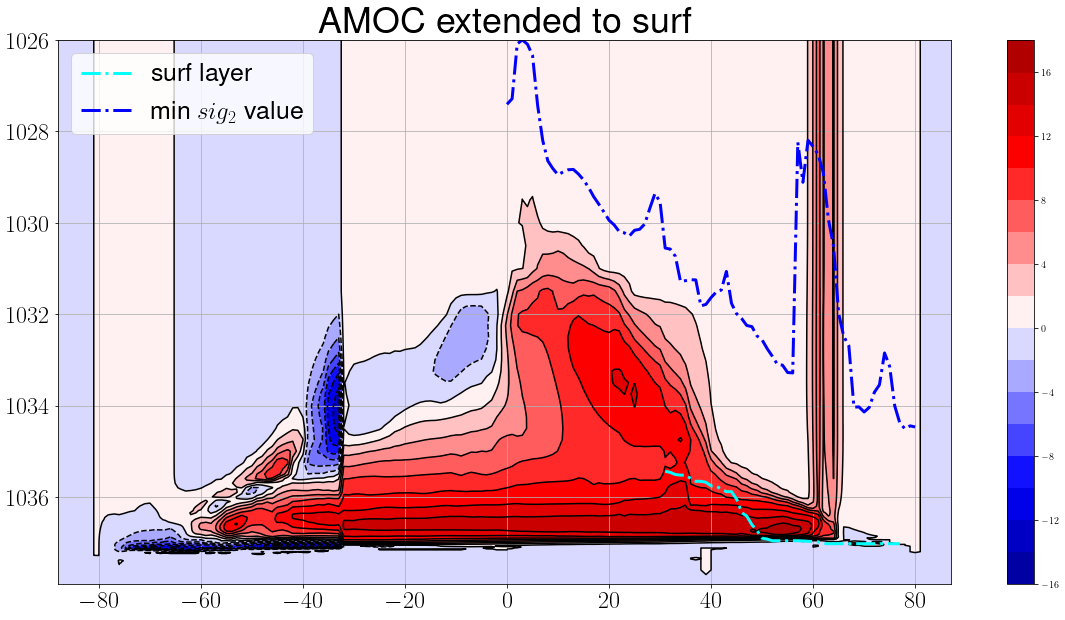

In [379]:
plt.figure(figsize=(20,10))
plt.contourf(AMOC_extended.lat,AMOC_extended.sig[:],(AMOC_extended)[:,:]/1e6,levels=20,cmap="seismic",vmin=-20,vmax=21)
plt.colorbar()
plt.contour(AMOC_extended.lat,AMOC_extended.sig[:],(AMOC_extended)[:,:]/1e6,colors="k",levels=20,vmin=-20,vmax=21)
plt.plot(ATL_sig_maxes_da.lat[:-10],ATL_sig_maxes_da[:-10],color="cyan",linewidth=3,label="surf layer",linestyle="dashdot")
plt.plot(ATL_sig_mins_indepth_da.lat,ATL_sig_mins_indepth_da,color="blue",linewidth=3,label="min $sig_{2}$ value",linestyle="dashdot")
plt.legend(fontsize=25,loc=2)
plt.title("AMOC extended to surf",fontsize=36)
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
plt.gca().invert_yaxis()
plt.grid()
plt.show()
plt.close()